## 8. Ablakolt Fourier-transzformációs módszer, WFTMethod


Ezt az eljárást szimulált interferogramon mutatom be. Példaként generálok egyet:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

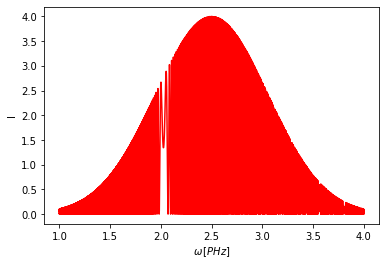

In [2]:
g = ps.Generator(1, 4, 2.5, delay=900, GDD=400, FOD=40000, pulse_width=3, resolution=0.05)
g.generate()

mywft = ps.WFTMethod(*g.data)
mywft.plot()

Ablakfüggvény sorozatot adok hozzá az interferogramhoz:

In [3]:
mywft.add_window_linspace(2.2, 3.1, 1000, fwhm=0.04, order=2)

**FONTOS!** 

Ha a fenti `add_window_linspace` lefutott, akkor az ablakfüggvény sorozat már hozzáadódott az interferogramhoz. Ha később megváltoztatnánk bármelyik paraméterét (pl. inkább más `fwhm`-ot szeretnénk beállítani), akkor az előző ablakfüggvények is megmaradak. Emiatt ajánlott a fenti cellát a következőképpen használni:

In [4]:
# az összes hozzáadott ablakfüggvény eltávolítása függetlenül attól, hogy korábban voltak-e
mywft.remove_all_windows()

# ezután adom hozzá az ablakfüggvény sorozatot
mywft.add_window_linspace(2.2, 3.1, 1000, fwhm=0.05, order=2)

Az aktuálisan hozzáadott ablakfüggvényeket a `WFTMethod.windows` paraméterrel érjük el, ami egy `dictionary`-t ad vissza, amelyben a *key* az ablakfüggvény központi helye, a hozzá tartozó *value* pedig maga az ablakfüggvény reprezentációja (`ps.core.window.GaussianWindow`). Az interferogram teljes tartományát a `cover(N, **kwargs)` függvénnyel gyorsabban is elvégezhetjük.

In [5]:
len(mywft.windows)

1000

Ablakfüggvényt törölni a `remove_window_at(center)` függvénnyel lehetséges. Ennek az ablakfüggvény központi helyét kell megadni. Ha nincs olyan ablakfüggvény, akkor a hibaüzenetben segítséget nyújt: kiiírja a legközelebbi ablakfüggvényt. Ablakfüggvény intervallum törléséhez a `remove_window_interval(start, stop)` függvény használható.

In [6]:
mywft.remove_window_at(2.25)

ValueError: There is no window with center 2.25. Did you mean 2.24954954954955?

Mivel ez a módszer ún. [*embarrassingly parallel*](https://en.wikipedia.org/wiki/Embarrassingly_parallel) számítás, ezért lehetőség van több szálon futtatni a kiértékelést. 
Ehhez a [*Dask*](https://dask.org/) csomagnak telepítve kell lennie (Anaconda-ban alapértelmezetten benne van). Ezt a `parallel` argumentummal szabályozhatjuk. A többszálas futás általában 50-70% gyorsulást eredményez a single-core módhoz képest. A kiértékelést most `parallel=True` módon fogom futtatni:

In [10]:
mywft.calculate(reference_point=2.5, order=4, fastmath=False, parallel=True);

[########################################] | 100% Completed |  9.2s
Skipped: 0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A fenti `calculate` függvény ha már egyszer lefutott és megpróbáljuk újra lefuttatni más referencia ponttal vagy más illesztési renddel, akkor a gyorsítótárazás miatt azok már azonnal végrehajtódnak (csak az illesztést számolja újra).

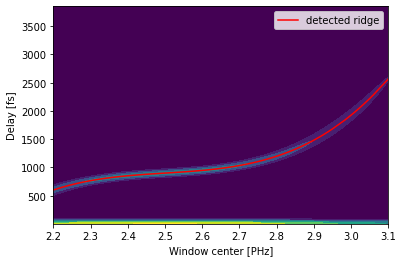

In [11]:
mywft.heatmap()

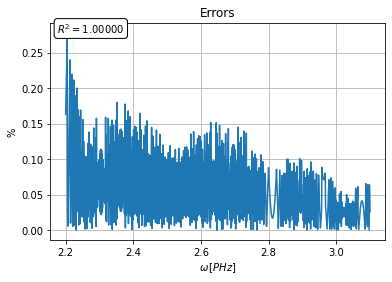

In [12]:
mywft.errorplot(percent=True)

Példa tetszőleges plotok készítésére:

c:\pyt\pysprint\pysprint\core\methods\wft.py:181: PySprintWarning: Image seems crowded, displaying only a subsample of the given windows.
  PySprintWarning
[ legend.py:1193 -   _parse_legend_args() ] No handles with labels found to put in legend.


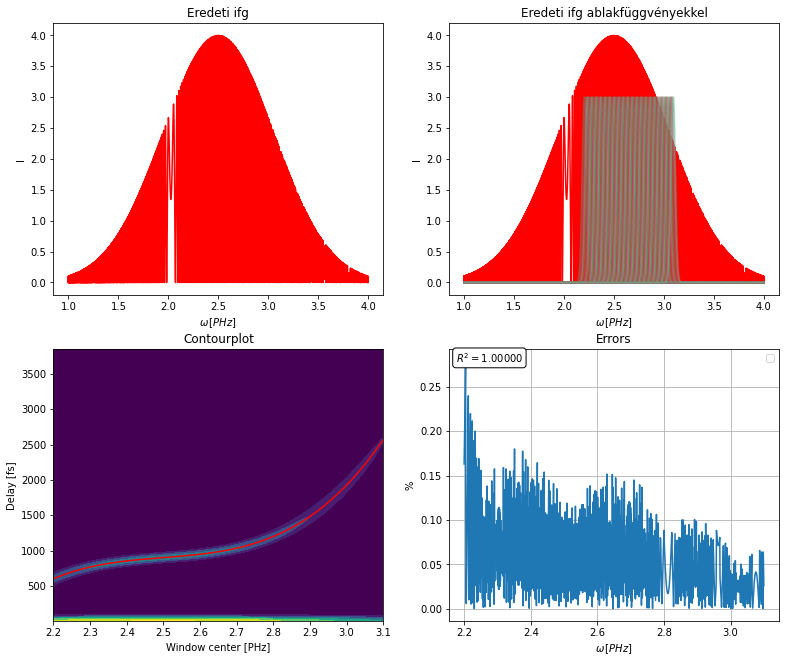

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))

mywft.plot(ax=ax1)
ax1.set(title="Eredeti ifg")

mywft.view_windows(ax=ax2, maxsize=200, alpha=0.3)
ax2.set(title="Eredeti ifg ablakfüggvényekkel")

mywft.heatmap(ax=ax3, include_ridge=True)
ax3.set(title="Contourplot");

mywft.errorplot(ax=ax4, percent=True)

Egy másik szimulált interferogram kiértékelését most `parallel=False` módon fogom elvégezni, és csak a `build_GD` függvényt használom, amivel a *GD* görbét kapom vissza (`ps.core.phase.Phase`).

In [14]:
f = ps.Generator(1, 4, 2.5, delay=1900, GDD=-600, TOD=4000, pulse_width=3, resolution=0.05)
f.generate()

mywft2 = ps.WFTMethod(*f.data)

In [15]:
mywft2.add_window_arange(1.5, 3.5, 0.01, std=0.04)

In [16]:
GD_gorbe = mywft2.build_GD()

Progress : [==============================] 100% (Skipped: 0)

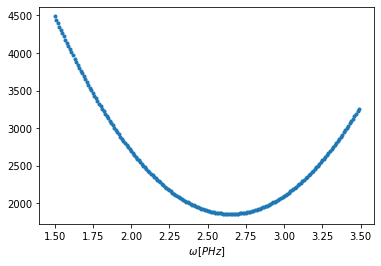

In [17]:
GD_gorbe.plot()

In [18]:
GD_gorbe.fit(reference_point=2.5, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

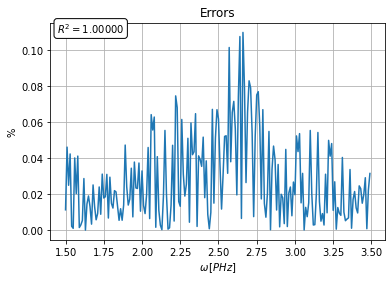

In [19]:
GD_gorbe.errorplot(percent=True)

A `fastmath` opciót itt nem adtam meg. Ez alapértelmezetten `True`, ilyenkor a `heatmap` nem hívható, mivel ekkor az ahhoz szükséges adatokat nem építi fel a program.

In [20]:
mywft2.heatmap()

ValueError: You need to recalculate with `fastmath=False` to plot the heatmap.

Néhány hiányosság: 

* A gerincvonalat a program automatikusan keresi meg, jelenleg még nincs lehetőség manuálisan állítani. Ez jól működik szimulált példákon, viszont rosszul is teljesíthet valós mérések esetén. Jelenleg ez a része a programnak fejlesztés alatt van (manuális állítás, különböző filterezése a detektált gerincvonalnak, pl. moving avarage validation.)


* Csak egyetlen egy gerincvonalat keres meg, így nem alkalmas pl. kettősen törő optikai szálak esetén, amikor mindkét polarizációs tengelye mentén terjedő módus egyidejűleg gerjesztve van. Szintén fejlesztés alatt van.


### 8.1 Saját ablakfüggvény használata

A program alapbeállításként Gauss ablakfüggvényeket használ, azonban néhány módosítással akár tetszőleges ablakfüggvényt is használhatunk. Tekintsünk most egy Mexican hat waveletet (vagy Ricker waveletet). Ez a következő alakú:

$A \cdot (1 - (\frac{x-x_0}{a})^2) \cdot e^{-0.5\cdot(\frac{x-x_0}{a})^2}$, ahol 
$A = \frac{2}{\sqrt{3a}\cdot\pi^{0.25}}$

A továbbiakban ezt a waveletet fogjuk példaként használni. Az első lépés a szükséges eszközök importálása. Itt két dologra van szükségünk, a `numpy` a numerikus rutinokra, illetve a `WindowBase` osztályra, amely a `pysprint.core.window` útvonalon érhető el.

```python
import numpy as np
from pysprint.core.window import WindowBase
```

Minden ablakfüggvényt a `WindowBase` alosztályaként kell definiálni. Az `__init__` szignatúrájában két kötelező argumentum van: `x` és `center`. Az `x` az adott interferogram x tengelyéből kerül a számítás közben megállításra. A `center` egy egyedi azonosítója az adott ablakfüggvénynek (pl. Gauss függvényeknél a maximum helye, a fenti waveletnél ezt $x_0$-val jelöltük). Minden osztály első argumentuma `self`, ezután definiáljuk a kötelező argumentumokat. Eddig ez így fest:

```python
import numpy as np
from pysprint.core.window import WindowBase

class MexicanHat(WindowBase):
    def __init__(self, x, center):
```

A wavelethez azonban kell egy másik paraméter is, ez az `a`. Minden használt paramétert meg kell adnunk az `__init__` metódusnak, így ezt is adjuk meg. A `self` kivételével az összes argumentumot az osztályhoz kell "kötni", hogy a további metódusokban is elérhetőek maradjanak. Tegyük meg:

```python
import numpy as np
from pysprint.core.window import WindowBase

class MexicanHat(WindowBase):
    def __init__(self, x, center, a):
        # a megadott paraméterek összekötése az osztállyal
        self.x = x
        self.center = center
        self.a = a
```
Természetesen alapértékeket is adhatuk az általunk használt paramétereknek (itt csak az `a`-nak), így számítás közben azokat használja majd a szoftver.
Esetünkben az `A` paraméter az `a` paraméterből számított, így arra az `__init__` metódusban nincs szükségünk. *Megjegyzés: Az* `__init__` *metódusban ne végezzük számolást, csak a paraméterek inicializálását. Bár ez nem szigorú szabály, mégis a számolásokat a legtöbbször meggyorsítja.*

A következő lépés, hogy definiáljuk hogyan számolhatóak ki az ablakfüggvény értékei. Ez egy ún. `property` lesz, amihez a decorator szintaxist használjuk. Ne aggódjunk, ennek megértése nem fontos és nem szükséges, tekintsünk rá úgy, mint recept. A megfelelő függvényt mindig nevezzük `y`-nak, amely egyetlen argumentumot fogad el, a `self`-et. A függvény testébe a matematikai formulákat és egyéb logikát írjuk, ami megmondja hogyan számoljuk ki az ablakfüggvény értékeit. Emlékezzünk vissza, az `__init__`-ben megadott paramétereket elérhetjük itt is! A fenti wavelet formuláját beírva kapjuk:
```python
@property
def y(self):
    # kiszámoljuk A-t
    A = 2 / (np.sqrt(3 * self.a) * (np.pi ** 0.25))
    # kiszámítjuk a formulából az értékeket
    ys = A * (1 - ((self.x - self.center) / self.a) ** 2) * np.exp(-0.5 * ((self.x - self.center) / self.a) ** 2)
    # visszaadjuk a kiszámított értékeket
    return ys
```
Összerakva az egészet:

In [21]:
import numpy as np
from pysprint.core.window import WindowBase

class MexicanHat(WindowBase):
    def __init__(self, x, center, a):
        self.x = x
        self.center = center
        self.a = a

    @property
    def y(self):
        A = 2 / (np.sqrt(3 * self.a) * (np.pi ** 0.25))
        ys = A * (1 - ((self.x - self.center) / self.a) ** 2) * np.exp(-0.5 * ((self.x - self.center) / self.a) ** 2)
        return ys


Ezen a ponton minden szükséges részletet megadtunk ahhoz, hogy a program használni tudja a MexicanHat ablakfüggvényt. Előtte azonban ellenőrizzük le, hogy valóban helyes-e a definíció. Minden `WindowBase` leszármazott osztálynak van `plot` metódusa. Próbáljuk ki azt!

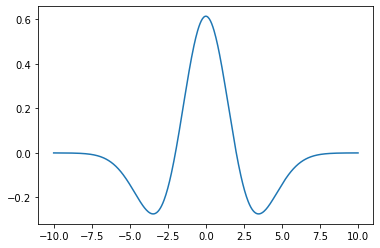

In [22]:
hat = MexicanHat(x=np.linspace(-10, 10, 500), center=0, a=2)
hat.plot()

Ez úgy tűnik helyesen adta vissza a kívánt ablakfüggvényt. Használjuk az Ablakot Fourier-transzformációs kiértékeléshez! A korábbiakkal teljesen analóg a számolás menete, egyetlen változtatás, hogy a `window_class` argumentumnak meg kell adnunk az általunk definiált `MexicanHat` osztályt.

In [23]:
g = ps.Generator(1, 4, 2.5, delay=900, GDD=400, FOD=40000, pulse_width=3, resolution=0.05)
g.generate()

custom_wft = ps.WFTMethod(g.x, g.y, window_class=MexicanHat)

Futtassuk a szokásos lépéseket: adjunk hozzá ablakfüggvény-sorozatot, futtassuk a kiértékelést.

In [24]:
custom_wft.add_window_linspace(2.2, 3, 500, a=0.01)

In [25]:
custom_wft.calculate(2.5, 4, fastmath=False, parallel=True, ransac=True);

[########################################] | 100% Completed |  5.0s
Skipped: 0
Running RANSAC-filter..
Values dropped: 52 (10.40000 % of total)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

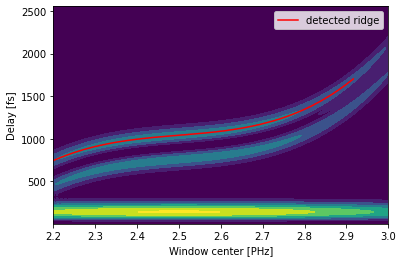

In [26]:
custom_wft.heatmap()

### 8.2 Egy teljes példa

A következőkben egy rossz minőségű interferogramon bemutatom hogyan hozható ki belőle a maximális mennyiségű értékes információ. Töltsük be és vizsgáljuk meg!

In [88]:
poor_ifg = ps.WFTMethod.parse_raw('datasets/ifg_poor.trt',
                                  skiprows=8,
                                  decimal=",",
                                  sep=";",
                                  meta_len=6)
poor_ifg.chdomain()

Megjegyzendő, hogy a betöltéssel azonos cellába tettem a tartományváltást, hogy biztosan ne futtassuk le többször az adott interferogramon.

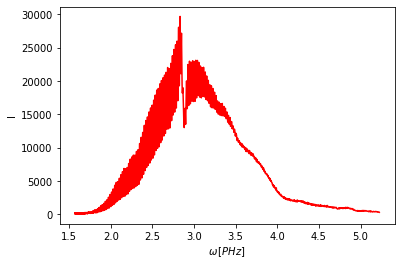

In [89]:
poor_ifg.plot()

Az első dolgunk, hogy eldöntsük milyen ablakfüggvény-sorozatot állítunk be. Itt egy rövidítést fogok használni, a `cover` függvényt, amely a teljes tartományt egyenközű módon fogja az ablakfüggvényekket kitölteni.

In [90]:
poor_ifg.cover(
    N=500, # db ablakfüggvény
    fwhm=0.05, # PHz az ablakfüggvény félértékszélessége
    order=2, # normál Gauss-függvény
)

Arra számítunk, hogy azonnali futás után nem adódik jó eredmény, a kapott GD görbén még dolgoznunk kell. Ehhez használjuk a `build_GD` függvényt.

In [91]:
gd = poor_ifg.build_GD(fastmath=False, parallel=True)

[########################################] | 100% Completed |  1.0s
Skipped: 85


Vizsgáljuk meg az eredményül kapott csoportkésleltetés görbét:

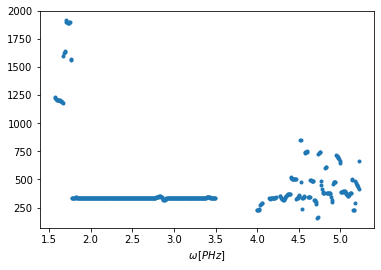

In [92]:
gd.plot()

Evidens, hogy a hasznos rész a 1.8 és 3.5 PHz közötti tartomány. Ezt vágjuk ki:

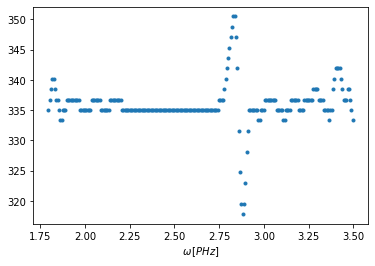

In [93]:
gd.slice(1.8, 3.5)
gd.plot()

A grafikon alapján rossznak tűnhet a helyzet, de a függőleges koordináta nagyságrendben különbözik az előző ábrától. Ezen a ponton illeszthetnénk is, de van még további mód a javításra. Használjuk az ún. [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) szűrést. Az algoritmus leírása túlmutat ezen oldal feladatán, a megadott linken olvashatunk róla. A `gd` objektumon a `ransac_filter` függvénnyel, illetve az `apply_filter` függvénnyel használható. Ugyan elsőrendű függvény várunk, mégis valamilyen kis nemzéró maradék diszperziója az üres spektrométernek is lehet. Emiatt a szűrést legalább másodrendben kell végeznünk, hogy a valódi zajt távolítsuk el, és ne a spektrométerre jellemző sajátosságokat.

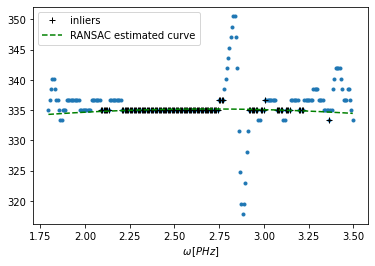

In [94]:
gd.ransac_filter(order=2, plot=True, residual_threshold=0.4)
plt.legend();

Ezzel intelligens módon kiszűrtük a zaj legnagyobb részét a csoportkésleltetés görbéből. Innen már nincs más dolgunk, mint alkalmazni a szűrőt, majd függvényt illeszteni és kiszámolni az együtthatókat.

In [95]:
gd.apply_filter()

Values dropped: 123 (52.78970 % of total)


In [96]:
gd.fit(reference_point=2.355, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>